In [35]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, InputLayer, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from keras.regularizers import l2
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error as mse

In [36]:
#create df of preprocessed data - game data from 2004-2024
df = pd.read_csv('nbaDatabasePreProcessed2004-2024-allPost (1).csv')
df

,date,homeTeam,homeTeam_id,homeTeam_win%,homeTeam_wins,homeTeam_losses,homeTeam_points_total,homeTeam_points_q1,homeTeam_points_q2,homeTeam_points_q3,...,awayTeam_D_Reb,awayTeam_Total_Reb,awayTeam_Ast,awayTeam_Stl,awayTeam_Blk,awayTeam_TO,awayTeam_PF,winner,season,isPlayoffGame
0,2024-06-17,Boston Celtics,BOS,0.792079,80,21,106,28,39,19,...,28,35,18,4,4,13,20,Boston Celtics,2023-2024,True
1,2024-06-14,Dallas Mavericks,DAL,0.611650,63,40,122,34,27,31,...,27,31,18,2,5,13,19,Dallas Mavericks,2023-2024,True
2,2024-06-12,Dallas Mavericks,DAL,0.607843,62,40,99,31,20,19,...,30,36,26,4,6,9,19,Boston Celtics,2023-2024,True
3,2024-06-09,Boston Celtics,BOS,0.795918,78,20,105,25,29,29,...,34,43,21,5,3,15,17,Boston Celtics,2023-2024,True
4,2024-06-06,Boston Celtics,BOS,0.793814,77,20,107,37,26,23,...,33,43,9,8,1,11,16,Boston Celtics,2023-2024,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25726,2004-11-03,Cleveland Cavaliers,CLE,0.000000,0,1,104,21,19,27,...,36,47,24,9,5,13,28,Indiana Pacers,2004-2005,False
25727,2004-11-03,Boston Celtics,BOS,0.000000,0,1,95,22,31,30,...,27,41,20,9,2,16,26,Philadelphia 76ers,2004-2005,False
25728,2004-11-02,Los Angeles Lakers,LAL,1.000000,1,0,89,24,26,22,...,32,48,17,10,8,16,21,Los Angeles Lakers,2004-2005,False
25729,2004-11-02,Detroit Pistons,DET,1.000000,1,0,87,19,18,22,...,27,36,8,4,5,16,24,Detroit Pistons,2004-2005,False


In [37]:
def plot_predictions1(model, X, y, start=0, end=100):
    predictions = model.predict(X).flatten()
    df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actuals'][start:end])
    return df, mse(y, predictions)

In [38]:
#maps franchises to subjectID
subjectID_dict = {
    "ATL": 1,
    "BOS": 2,
    "BKN": 3,
    "CHA": 4,
    "CHI": 5,
    "CLE": 6,
    "DAL": 7,
    "DEN": 8,
    "DET": 9,
    "GSW": 10,
    "HOU": 11,
    "IND": 12,
    "LAC": 13,
    "LAL": 14,
    "MEM": 15,
    "MIA": 16,
    "MIL": 17,
    "MIN": 18,
    "NOP": 19,
    "NYK": 20,
    "OKC": 21,
    "ORL": 22,
    "PHI": 23,
    "PHX": 24,
    "POR": 25,
    "SAC": 26,
    "SAS": 27,
    "TOR": 28,
    "UTA": 29,
    "WAS": 30,
    "NOH": 19, #New Orleans Hornets is same franchise as NOP- New Orleans Pelicans
    "NJN": 3, #New Jersey Nets relocated to Brooklyn
    "SEA": 21, #Seattle Supersonics Relocated to OKC
    "NOK": 19, #New Orleans Hornets relocated to OKC 2005-2007 - Eventually became New Orleans Pelicans
    
}

In [39]:
#map the subject IDs to a number to handle franchise moves
df["homeTeamSubject_id"] = df["homeTeam_id"].map(subjectID_dict)
df["awayTeamSubject_id"] = df["awayTeam_id"].map(subjectID_dict)

cols = df.columns.tolist()
cols.insert(cols.index("homeTeam_id") + 1, cols.pop(cols.index("homeTeamSubject_id")))
cols.insert(cols.index("awayTeam_id") + 1, cols.pop(cols.index("awayTeamSubject_id")))
df = df[cols]

df

,date,homeTeam,homeTeam_id,homeTeamSubject_id,homeTeam_win%,homeTeam_wins,homeTeam_losses,homeTeam_points_total,homeTeam_points_q1,homeTeam_points_q2,...,awayTeam_D_Reb,awayTeam_Total_Reb,awayTeam_Ast,awayTeam_Stl,awayTeam_Blk,awayTeam_TO,awayTeam_PF,winner,season,isPlayoffGame
0,2024-06-17,Boston Celtics,BOS,2,0.792079,80,21,106,28,39,...,28,35,18,4,4,13,20,Boston Celtics,2023-2024,True
1,2024-06-14,Dallas Mavericks,DAL,7,0.611650,63,40,122,34,27,...,27,31,18,2,5,13,19,Dallas Mavericks,2023-2024,True
2,2024-06-12,Dallas Mavericks,DAL,7,0.607843,62,40,99,31,20,...,30,36,26,4,6,9,19,Boston Celtics,2023-2024,True
3,2024-06-09,Boston Celtics,BOS,2,0.795918,78,20,105,25,29,...,34,43,21,5,3,15,17,Boston Celtics,2023-2024,True
4,2024-06-06,Boston Celtics,BOS,2,0.793814,77,20,107,37,26,...,33,43,9,8,1,11,16,Boston Celtics,2023-2024,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25726,2004-11-03,Cleveland Cavaliers,CLE,6,0.000000,0,1,104,21,19,...,36,47,24,9,5,13,28,Indiana Pacers,2004-2005,False
25727,2004-11-03,Boston Celtics,BOS,2,0.000000,0,1,95,22,31,...,27,41,20,9,2,16,26,Philadelphia 76ers,2004-2005,False
25728,2004-11-02,Los Angeles Lakers,LAL,14,1.000000,1,0,89,24,26,...,32,48,17,10,8,16,21,Los Angeles Lakers,2004-2005,False
25729,2004-11-02,Detroit Pistons,DET,9,1.000000,1,0,87,19,18,...,27,36,8,4,5,16,24,Detroit Pistons,2004-2005,False


In [40]:
#generate a binary winner column
df['winner_binary'] = (df['winner'] == df['awayTeam']).astype(int)
df

C:\Users\Max Braithwaite\AppData\Local\Temp\ipykernel_25456\767967889.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['winner_binary'] = (df['winner'] == df['awayTeam']).astype(int)


,date,homeTeam,homeTeam_id,homeTeamSubject_id,homeTeam_win%,homeTeam_wins,homeTeam_losses,homeTeam_points_total,homeTeam_points_q1,homeTeam_points_q2,...,awayTeam_Total_Reb,awayTeam_Ast,awayTeam_Stl,awayTeam_Blk,awayTeam_TO,awayTeam_PF,winner,season,isPlayoffGame,winner_binary
0,2024-06-17,Boston Celtics,BOS,2,0.792079,80,21,106,28,39,...,35,18,4,4,13,20,Boston Celtics,2023-2024,True,0
1,2024-06-14,Dallas Mavericks,DAL,7,0.611650,63,40,122,34,27,...,31,18,2,5,13,19,Dallas Mavericks,2023-2024,True,0
2,2024-06-12,Dallas Mavericks,DAL,7,0.607843,62,40,99,31,20,...,36,26,4,6,9,19,Boston Celtics,2023-2024,True,1
3,2024-06-09,Boston Celtics,BOS,2,0.795918,78,20,105,25,29,...,43,21,5,3,15,17,Boston Celtics,2023-2024,True,0
4,2024-06-06,Boston Celtics,BOS,2,0.793814,77,20,107,37,26,...,43,9,8,1,11,16,Boston Celtics,2023-2024,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25726,2004-11-03,Cleveland Cavaliers,CLE,6,0.000000,0,1,104,21,19,...,47,24,9,5,13,28,Indiana Pacers,2004-2005,False,1
25727,2004-11-03,Boston Celtics,BOS,2,0.000000,0,1,95,22,31,...,41,20,9,2,16,26,Philadelphia 76ers,2004-2005,False,1
25728,2004-11-02,Los Angeles Lakers,LAL,14,1.000000,1,0,89,24,26,...,48,17,10,8,16,21,Los Angeles Lakers,2004-2005,False,0
25729,2004-11-02,Detroit Pistons,DET,9,1.000000,1,0,87,19,18,...,36,8,4,5,16,24,Detroit Pistons,2004-2005,False,0


In [41]:
#populate dfIDtoStat - should be double the size of df
homedf = df[['date', 'homeTeamSubject_id', 'homeTeam_wins', 'homeTeam_losses', 'homeTeam_points_total']]
homedf.columns = ['date', 'team_id', 'team_wins', 'team_losses', 'team_points_total']
awaydf = df[['date', 'awayTeamSubject_id', 'awayTeam_wins', 'awayTeam_losses', 'awayTeam_points_total']]
awaydf.columns = ['date', 'team_id', 'team_wins', 'team_losses', 'team_points_total']

dfIDtoStat = pd.concat([homedf, awaydf], ignore_index=True)
dfIDtoStat

,date,team_id,team_wins,team_losses,team_points_total
0,2024-06-17,2,80,21,106
1,2024-06-14,7,63,40,122
2,2024-06-12,7,62,40,99
3,2024-06-09,2,78,20,105
4,2024-06-06,2,77,20,107
...,...,...,...,...,...
51457,2004-11-03,12,1,0,109
51458,2004-11-03,23,1,0,98
51459,2004-11-02,8,0,1,78
51460,2004-11-02,11,0,1,79


In [42]:
windowConditions = {
    'team_win%': False,
    'team_wins': False,
    'team_losses': False,
    'team_points_total': True,
    'team_points_q1': True,
    'team_points_q2': True,
    'team_points_q3': True,
    'team_points_q4': True,
    'team_FG': True,
    'team_FG_made': True,
    'team_3P': True,
    'team_3P_made': True,
    'team_O_Reb': True,
    'team_D_Reb': True,
    'team_Total_Reb': True,
    'team_Ast': True,
    'team_Stl': True,
    'team_Blk': True,
    'team_TO': True,
    'team_PF': True,
}

In [46]:
#showcase of the first iteration
window_size = 3
exX =[]
exY = []
for index, row in df.iterrows():
        homeTeam_id = row['homeTeamSubject_id']
        awayTeam_id = row['awayTeamSubject_id']
        date = row['date']
        #limit dfWindow to include rows that occured before date of row we are on
        dfWindow_before_date = dfIDtoStat[dfIDtoStat['date']< date]
        homeTeam_occurrences = dfWindow_before_date[dfWindow_before_date['team_id'] == homeTeam_id].shape[0]
        awayTeam_occurrences = dfWindow_before_date[dfWindow_before_date['team_id'] == awayTeam_id].shape[0]
        if homeTeam_occurrences > window_size and awayTeam_occurrences > window_size:
                homeTeam_window = (dfWindow_before_date[dfWindow_before_date['team_id'] == homeTeam_id].sort_values(by='date', ascending=False).head(window_size))
                awayTeam_window = (dfWindow_before_date[dfWindow_before_date['team_id'] == awayTeam_id].sort_values(by='date', ascending=False).head(window_size))
                print(date)
                print(homeTeam_window)
                print(awayTeam_window)
                print(type(homeTeam_window))
                homeTeam_window = homeTeam_window.drop(columns=['date', 'team_id'])
                #condtional for average or top entry - home Team
                true_cols = [col for col, val in windowConditions.items() if val and col in homeTeam_window.columns]
                false_cols = [col for col, val in windowConditions.items() if not val and col in homeTeam_window.columns]
                homeTeam_window = np.concatenate([homeTeam_window[false_cols].iloc[0].to_numpy(), homeTeam_window[true_cols].mean(axis=0).to_numpy()])
                awayTeam_window = awayTeam_window.drop(columns=['date', 'team_id'])
                #conditional for average or top entry - away Team
                true_cols = [col for col, val in windowConditions.items() if val and col in awayTeam_window.columns]
                false_cols = [col for col, val in windowConditions.items() if not val and col in awayTeam_window.columns]
                awayTeam_window = np.concatenate([awayTeam_window[false_cols].iloc[0].to_numpy(), awayTeam_window[true_cols].mean(axis=0).to_numpy()])
                combined_window = np.hstack((homeTeam_window, awayTeam_window))
                exX.append(combined_window)
                exY.append(row['homeTeam_points_total'])
                print(exX)
                print(exY)
                break

2024-06-17
             date  team_id  team_wins  team_losses  team_points_total
25732  2024-06-14        2         79           21                 84
25733  2024-06-12        2         79           20                106
3      2024-06-09        2         78           20                105
             date  team_id  team_wins  team_losses  team_points_total
1      2024-06-14        7         63           40                122
2      2024-06-12        7         62           40                 99
25734  2024-06-09        7         62           39                 98
<class 'pandas.core.frame.DataFrame'>
[array([ 79.        ,  21.        ,  98.33333333,  63.        ,
        40.        , 106.33333333])]
[106]


In [47]:
#generate the X Y matrices
def df_to_X_y(df, dfWindow, window_size):
    X = []
    y = []
    #each team must have played window_size games before data can be extracted
    for index, row in df.iterrows():
        homeTeam_id = row['homeTeamSubject_id']
        awayTeam_id = row['awayTeamSubject_id']
        date = row['date']
        #limit dfWindow to include rows that occured before date of row we are on
        dfWindow_before_date = dfWindow[dfWindow['date']< date]
        homeTeam_occurrences = dfWindow_before_date[dfWindow_before_date['team_id'] == homeTeam_id].shape[0]
        awayTeam_occurrences = dfWindow_before_date[dfWindow_before_date['team_id'] == awayTeam_id].shape[0]
        if homeTeam_occurrences > window_size and awayTeam_occurrences > window_size:
            homeTeam_window = (dfWindow_before_date[dfWindow_before_date['team_id'] == homeTeam_id].sort_values(by='date', ascending=False).head(window_size).drop(columns=['date', 'team_id']))
            awayTeam_window = (dfWindow_before_date[dfWindow_before_date['team_id'] == awayTeam_id].sort_values(by='date', ascending=False).head(window_size).drop(columns=['date', 'team_id']))
            #condtional for average or top entry - home Team
            true_cols = [col for col, val in windowConditions.items() if val and col in homeTeam_window.columns]
            false_cols = [col for col, val in windowConditions.items() if not val and col in homeTeam_window.columns]
            homeTeam_window = np.concatenate([homeTeam_window[false_cols].iloc[0].to_numpy(), homeTeam_window[true_cols].mean(axis=0).to_numpy()])
            #conditional for average or top entry - away Team
            true_cols = [col for col, val in windowConditions.items() if val and col in awayTeam_window.columns]
            false_cols = [col for col, val in windowConditions.items() if not val and col in awayTeam_window.columns]
            awayTeam_window = np.concatenate([awayTeam_window[false_cols].iloc[0].to_numpy(), awayTeam_window[true_cols].mean(axis=0).to_numpy()])
            combined_window = np.hstack((homeTeam_window, awayTeam_window))
            X.append(combined_window)
            y.append(row['homeTeam_points_total'])
    
    return np.array(X), np.array(y)

In [48]:
#X1.Shape is num data, window size, variables
X, y = df_to_X_y(df, dfIDtoStat, 5)
X.shape, y.shape

((25634, 6), (25634,))

In [53]:
#80-10-10 split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((20507, 6), (20507,), (2563, 6), (2563,), (2564, 6), (2564,))

In [54]:
model = Sequential()
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

In [55]:
earlystopping = EarlyStopping(monitor='val_root_mean_squared_error', patience=50, restore_best_weights=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [56]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, callbacks=[earlystopping])


Epoch 1/1000
641/641 [==============================] - 1s 1ms/step - loss: 7107.6123 - root_mean_squared_error: 84.3067 - val_loss: 2205.6365 - val_root_mean_squared_error: 46.9642
Epoch 2/1000
641/641 [==============================] - 1s 900us/step - loss: 511.4019 - root_mean_squared_error: 22.6142 - val_loss: 189.8841 - val_root_mean_squared_error: 13.7798
Epoch 3/1000
641/641 [==============================] - 1s 896us/step - loss: 171.9675 - root_mean_squared_error: 13.1136 - val_loss: 176.7314 - val_root_mean_squared_error: 13.2940
Epoch 4/1000
641/641 [==============================] - 1s 880us/step - loss: 161.8530 - root_mean_squared_error: 12.7221 - val_loss: 167.5122 - val_root_mean_squared_error: 12.9426
Epoch 5/1000
641/641 [==============================] - 1s 864us/step - loss: 154.0796 - root_mean_squared_error: 12.4129 - val_loss: 159.5695 - val_root_mean_squared_error: 12.6321
Epoch 6/1000
641/641 [==============================] - 1s 864us/step - loss: 147.9917 - r

81/81 [==============================] - 0s 638us/step


(      Predictions  Actuals
 0      101.519150      108
 1      100.354050       86
 2       93.598320       87
 3       98.915260      104
 4      104.729118       99
 ...           ...      ...
 2559    94.260544       86
 2560    99.773483       94
 2561   119.184418      113
 2562   101.627510       98
 2563    99.824516       94
 
 [2564 rows x 2 columns],
 133.29130846570155)

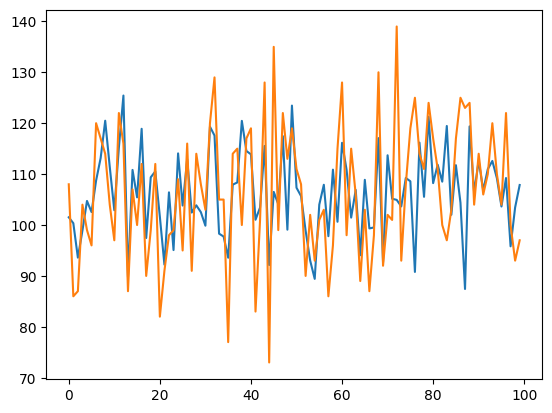

In [57]:
plot_predictions1(model, X_test, y_test)